* Spearmint for analogy reasoning
* Gaussian LDA
* Evaluate word analogy reasoning
* find background noise
* find word pairs
* evaluate topic coherence (illustrate topic model differences)

# Setup

In [1]:
%matplotlib notebook

import itertools
from functools import partial
import numpy as np
import gensim, logging
import pandas as pnd
from sklearn.cluster import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, RandomizedPCA
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [2]:
MODEL = "../models/topic-models/topic.full.fixed-vocabulary.alpha-1-100.256-400.model"

# Preprocessing

In [3]:
SKIP_GRAM_VECTOR_FILE = "/home/knub/Repositories/master-thesis/models/word-embeddings/embedding.model.skip-gram"
vectors = gensim.models.Word2Vec.load_word2vec_format(SKIP_GRAM_VECTOR_FILE, binary=True)

## Topic Probs

In [4]:
prob_columns = list(range(256))
df_probs = pnd.read_csv(MODEL + ".topic-probs")
df_probs.head(1)

,word,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,telenovela,1.316723e-09,1.981514e-09,4.121432e-09,1.833986e-09,4.728217e-10,3.481988e-09,1.712372e-09,2.034031e-09,2.901264e-09,...,2.173630e-09,2.033049e-09,2.443655e-09,1.878764e-09,3.913604e-09,3.447599e-09,1.489039e-09,1.602794e-09,3.104720e-09,1.582650e-09


## Topics

In [5]:
df_topics = pnd.read_csv(MODEL + ".ssv", sep=" ", encoding="utf-8")
topic_words = set(df_topics.ix[:,-10:].values.flatten())
df_topics.tail(10)

,topic,topic-count,0,1,2,3,4,5,6,7,8,9
246,111,1649204,pope,buddhist,cardinal,catholic,buddhism,tibetan,buddha,vatican,also,monastery
247,166,1646455,age,population,census,median,income,county,average,living,years,households
248,2,1645190,colorado,utah,arizona,county,national,nevada,montana,states,state,idaho
249,150,1635750,store,stores,mall,chain,opened,shopping,retail,company,new,also
250,209,1610602,singapore,malaysia,indonesia,indonesian,malaysian,malay,also,east,java,kuala
251,45,1586894,romania,romanian,river,district,hungarian,hungary,oblast,administrative,settlement,name
252,44,1564227,population,swiss,municipality,switzerland,people,sector,years,canton,total,made
253,151,1481094,philippines,philippine,manila,filipino,city,san,also,first,province,spanish
254,75,1143084,hill,thailand,thai,cornwall,district,bangkok,province,cornish,devon,village
255,236,1054201,wales,welsh,cardiff,morgan,davies,newport,arthur,jones,knight,swansea


## Similars

In [6]:
df_similars = pnd.read_csv(MODEL + ".similars", sep="\t", header=None, encoding="utf-8")
df_similars["tm_sim"] = 1 - df_similars[0]
del df_similars[0]
del df_similars[1]
df_similars.columns = ["word", "similars", "tm_sim"]
df_similars.head(10)
#df_similars[["word", "similars"]].apply(lambda x: vectors.similarity(x, y))
df_similars["we_sim"] = df_similars[["word", "similars"]].apply(lambda x: vectors.similarity(x["word"], x["similars"]), axis=1)
df_similars = df_similars[df_similars["word"] != df_similars["similars"]]
df_similars

,word,similars,tm_sim,we_sim
1,development,developed,0.960519,0.360895
2,development,project,0.942942,0.504817
3,development,provide,0.940691,0.241174
4,development,projects,0.939511,0.516865
5,development,environment,0.937581,0.501580
6,development,resources,0.936089,0.433210
7,development,management,0.934974,0.585662
8,development,provides,0.934541,0.285024
9,development,technical,0.932800,0.395042
11,public,private,0.940867,0.626080


# Analysis

## Topic Probs

In [7]:
df_probs["mean"] = df_probs[prob_columns].mean(axis=1)
df_probs["stddev"] = df_probs[prob_columns].std(axis=1)
df_probs = df_probs[df_probs.word.apply(lambda w: w in topic_words)]

### Highest mean

In [8]:
df_probs.sort_values(by="mean", ascending=False).head(10)[["word", "mean"]]

,word,mean
188,also,0.004890
430,first,0.004132
797,new,0.003872
169,one,0.003562
302,two,0.002967
35,may,0.002070
279,school,0.001927
546,city,0.001817
414,world,0.001808
483,time,0.001788


### Lowest mean

In [9]:
df_probs.sort_values(by="mean", ascending=True).head(10)[["word", "mean"]]

,word,mean
1193,symphony,0.000014
17527,superman,0.000025
28544,voltage,0.000025
6848,cuisine,0.000025
44949,nerve,0.000027
16897,dundee,0.000027
6849,cooking,0.000029
15956,byzantine,0.000029
13717,genes,0.000029
29709,kuala,0.000030


### Highest std. dev.

In [10]:
df_probs.sort_values(by="stddev", ascending=False).head(10)[["word", "stddev"]]

,word,stddev
797,new,0.013168
279,school,0.011742
699,film,0.009937
4859,station,0.008415
1161,york,0.008400
472,district,0.007070
297,university,0.006586
5365,population,0.006052
1043,county,0.005956
2151,age,0.005936


### Lowest std. dev.

In [11]:
df_probs.sort_values(by="stddev", ascending=True).head(10)[["word", "stddev"]]

,word,stddev
1193,symphony,0.000156
1194,orchestra,0.000250
15,soap,0.000266
15956,byzantine,0.000275
7024,evil,0.000297
16307,tissue,0.000309
17527,superman,0.000310
12521,extinct,0.000318
1199,jacques,0.000320
9586,organic,0.000322


## Correlation TM similarity and WE similarity

In [16]:
df_similars[["tm_sim", "we_sim"]].corr("pearson")

,tm_sim,we_sim
tm_sim,1.000000,0.407297
we_sim,0.407297,1.000000


### Distribution of TM similarity
Note that this is skewed, because we only take the highest

<IPython.core.display.Javascript object>


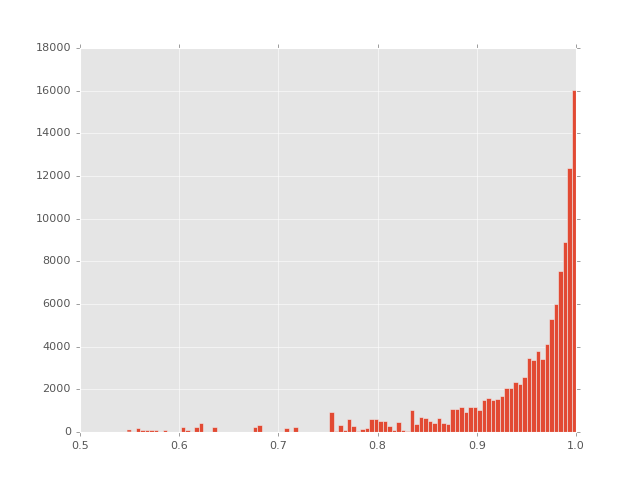

In [13]:
plt.figure()
df_similars["tm_sim"].hist(bins=100)

<IPython.core.display.Javascript object>


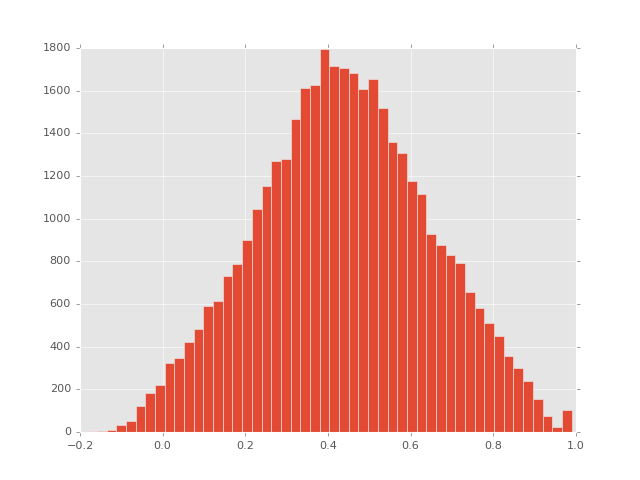

In [37]:
plt.figure()
df_similars["we_sim"].hist(bins=50)

In [14]:
we_percentile = df_similars["we_sim"].quantile(q=.30)
we_percentile

0.2457466954467814

In [15]:
df_large_sim_diff = df_similars[df_similars["we_sim"] < we_percentile]
df_large_sim_diff

,word,similars,tm_sim,we_sim
3,development,provide,0.940691,0.241174
12,public,board,0.916731,0.243314
15,public,activities,0.912286,0.140921
16,public,report,0.912188,0.126750
17,public,provide,0.911599,0.221968
33,program,organizations,0.942505,0.245747
58,community,post,0.919742,0.051408
59,community,established,0.919478,0.204145
61,national,former,0.813083,0.137820
64,national,currently,0.801159,0.056121


# Findings

* syntatic variations play a bigger role in WE models, example:

  **(development, developed)**: TM-sim: 0.960519 WE-SIM: 0.360895
  
  **(composed, composers)** TM-SIM: 0.973376 WE-SIM: 0.329483